<a href="https://colab.research.google.com/github/nupursjsu/Deep-Learning/blob/master/MNIST_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing MNIST classifier using numpy and python

In [0]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import trange
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Loading the MNIST dataset

In [0]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Loading the MNIST dataset returns four numpy arrays. The images are numpy arrays of 28X28 with pixel values ranging from 0 to 255. The labels are an array of integers with values 0 to 9. 

## Exploring the MNIST dataset

In [104]:
# Checking the shape of the training data
train_images.shape

(60000, 28, 28)

The training data contains 60000 images of 28 by 28 pixels.

In [105]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

train_labels consists of labels that range from digit 0 to 9.

In [106]:
# Checking the shape of the test data
test_images.shape

(10000, 28, 28)

The training data contains 10000 images of 28 by 28 pixels.



## Preprocessing the data

### Scaling the input

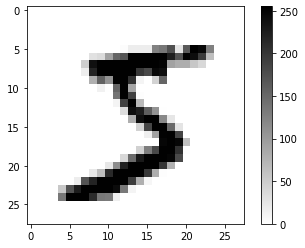

In [107]:
# Inspecting the first image in our training set
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

We can see in the above image that the pixel value ranges from 0 to 255. So, we need to scale these values to a range of 0 to 1 before feeding the data to the model. We need to preprocess both the training data as well as test data.

In [0]:
train_images = train_images.astype(float)/255.
test_images = test_images.astype(float)/255.

### Augmenting data to prevent overfitting

In [0]:
def augment_imagedata(df, df_labels, aug_factor=1, random_rotation=True, random_shear=True, random_shift=True):
	aug_image = []
	aug_image_labels = []

	for num in range (0, df.shape[0]):

		for i in range(0, aug_factor):
			# original image:
			aug_image.append(df[num])
			aug_image_labels.append(df_labels[num])

			if random_rotation:
				aug_image.append(tf.contrib.keras.preprocessing.image.random_rotation(df[num], 20, row_axis=0, col_axis=1, channel_axis=2))
				aug_image_labels.append(df_labels[num])

			if random_shear:
				aug_image.append(tf.contrib.keras.preprocessing.image.random_shear(df[num], 0.2, row_axis=0, col_axis=1, channel_axis=2))
				aug_image_labels.append(df_labels[num])

			if random_shift:
				aug_image.append(tf.contrib.keras.preprocessing.image.random_shift(df[num], 0.2, 0.2, row_axis=0, col_axis=1, channel_axis=2))
				aug_image_labels.append(df_labels[num])

	return np.array(aug_image), np.array(aug_image_labels)

In [0]:
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
train_images, train_labels = augment_imagedata(train_images, train_labels, aug_factor=1, random_rotation=True, random_shift=True, random_shear=True)


In [111]:
print(train_images.shape, test_images.shape)

(240000, 28, 28, 1) (10000, 28, 28)


The number of images in the training set has increased from **60000 to 240000 after data augmentation.**

Displaying the first 25 images after data augmentation to verify if our data is in the correct format or not before building and training our model.

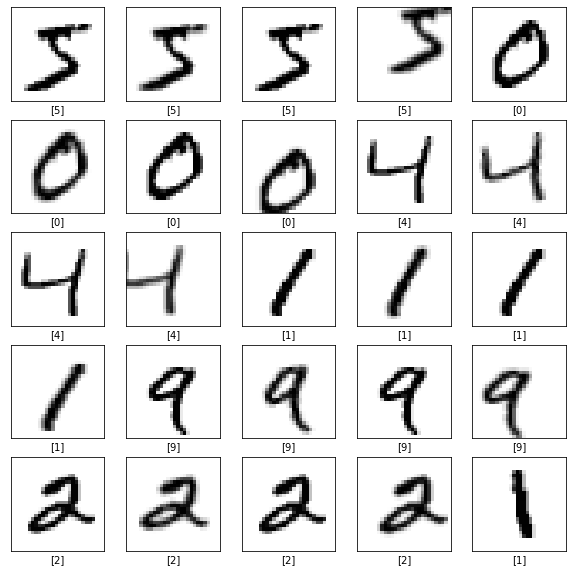

In [112]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel([train_labels[i]])
plt.show()

### Flattening the train and test sets

In [0]:
train_images = train_images.reshape([train_images.shape[0], -1])
test_images = test_images.reshape([test_images.shape[0], -1])

In [114]:
print(train_images.shape, test_images.shape)

(240000, 784) (10000, 784)


In [115]:
print(train_labels.shape, test_labels.shape)

(240000,) (10000,)


## Building our own neural network

### Creating network layer

In [0]:
class NetworkLayer:
  def __init__(self):
    self.weights = np.zeros(shape=(X.shape[1], 10))
    bias = np.zeros(shape=(10,))

  def fwd(self, input):
        output = np.matmul(input, self.weights) + bias
        return output

### Creating dense network layer and passing learning rate (alpha) as input to it.

In [0]:
class DenseNetworkLayer(NetworkLayer):
    def __init__(self, inputs, outputs, alpha=0.1):
        # initializing weights as small random numbers using normal distribution
        self.weights = np.random.randn(inputs, outputs)*0.01
        self.bias = np.zeros(outputs)
        self.alpha = alpha

    def fwd(self,input):
        return np.matmul(input, self.weights) + self.bias

    def bwd(self,input,grad_output):
        grad_input = np.dot(grad_output,np.transpose(self.weights))
        grad_weights = np.transpose(np.dot(np.transpose(grad_output),input))
        grad_bias = np.sum(grad_output, axis = 0)
        # using stochastic gradient descent method in our model
        self.bias = self.bias - self.alpha * grad_bias
        self.weights = self.weights - self.alpha * grad_weights
        return grad_input

### Creating Activation class (using ReLu)

In [0]:
class ReLu(NetworkLayer):
    def __init__(self):
        pass

    def fwd(self, input):
        return np.maximum(0,input)

    def bwd(self, input, grad_output):
        return grad_output*(input > 0)

### Defining loss function

In [0]:
def crossentropy(lg,res):
    ans = lg[np.arange(len(lg)),res]
    f_Entropy = - ans + np.log(np.sum(np.exp(lg),axis=-1))
    return f_Entropy

def grad_crossentropy(lg,res):
    one_ans = np.zeros_like(lg)
    one_ans[np.arange(len(lg)),res] = 1 
    softmax = np.exp(lg) / np.exp(lg).sum(axis=-1,keepdims=True) 
    return (- one_ans + softmax) / lg.shape[0]

### Defining our 3 layers network model using RELU as activation layer. Also, using different learning rates at different layers

In [0]:
#creating a list for our network layers
nn = []
#defining input layer
nn.append(DenseNetworkLayer(train_images.shape[1],200))
nn.append(ReLu())
#defining Hidden_Layer 1
nn.append(DenseNetworkLayer(200,100,alpha=0.5))
nn.append(ReLu())
#defining Hidden_Layer 2
nn.append(DenseNetworkLayer(100,200,alpha=0.3))
nn.append(ReLu())
#defining output layer
nn.append(DenseNetworkLayer(200,10))

### Passing the above created neural network list to the forward function as input and iterating through all the defined layers.

In [0]:
def fwd(nn, batch):
  res = []
  input = batch
  for i in range(len(nn)):
    res.append(nn[i].fwd(batch))
    batch = nn[i].fwd(batch)
  assert len(res) == len(nn)
  return res

### Making predictions on our neural network

In [0]:
def pred(nn,batch):
  lg = fwd(nn,batch)[-1]
  return lg.argmax(axis=-1)

### Using batch 'a' and 'b' to train our network batch

In [0]:
def trainNetwork(nn,a,b):
  #getting layer activations for our model
  l_act = fwd(nn,a)
  lg = l_act[-1]
    
  #computing init gradient and loss
  loss = crossentropy(lg,b)
  layer_grad = grad_crossentropy(lg,b)
  for i in range(1, len(nn)):
      layer_grad = nn[len(nn) - i].bwd(l_act[len(nn) - i - 1], layer_grad)
  return np.mean(loss)

### Defining minibatch gradient descent

In [0]:
def miniBatchGrad(inputs, res, batch_size, shuffle=False):
    assert len(inputs) == len(res)
    if shuffle:
        idx = np.random.permutation(len(inputs))
    for idx_1 in trange(0, len(inputs) - batch_size + 1, batch_size):
        if shuffle:
            x = idx[idx_1:idx_1 + batch_size]
        else:
            x = slice(idx_1, idx_1 + batch_size)
        yield inputs[x], res[x]

## Training our model using minibatch gradient descent

In [125]:
#Creating below two lists to store the values obtained for each cycle
train_log = []
test_log = []

for i in range(5):
  #using minibatch function for obtaining training data batches
  for batch_1,batch_2 in miniBatchGrad(train_images,train_labels,batch_size=32,shuffle=True):
    trainNetwork(nn,batch_1,batch_2)
  #updating lists with each cycle results accuracies
  train_log.append(np.mean(pred(nn,train_images)==train_labels))
  test_log.append(np.mean(pred(nn,test_images)==test_labels))
    
  #displaying the results obtained
  print("\n Cycle",i)
  print("\n Training accuracy:",train_log[-1])
  print("\n Test accuracy:",test_log[-1])

  0%|          | 32/7500 [00:00<00:23, 317.04it/s]


 Cycle 0

 Training accuracy: 0.8505958333333333

 Test accuracy: 0.9266


  0%|          | 36/7500 [00:00<00:20, 355.52it/s]


 Cycle 1

 Training accuracy: 0.8957458333333334

 Test accuracy: 0.9475


  1%|          | 39/7500 [00:00<00:19, 387.98it/s]


 Cycle 2

 Training accuracy: 0.9210208333333333

 Test accuracy: 0.9545


  1%|          | 38/7500 [00:00<00:19, 378.30it/s]


 Cycle 3

 Training accuracy: 0.9361166666666667

 Test accuracy: 0.9597


100%|██████████| 7500/7500 [00:20<00:00, 362.34it/s]



 Cycle 4

 Training accuracy: 0.9430583333333333

 Test accuracy: 0.9626


## Evaluating model

In [0]:
# Predicting the labels for the test dataset
y_pred = pred(nn, test_images)

In [127]:
# Computing accuracy for test data prediction
from sklearn.metrics import accuracy_score
accuracy_score(test_labels,y_pred)*100

96.26

**Our model is yielding an accuracy of approx 96% which is pretty good.**

### Confusion Matrix plot

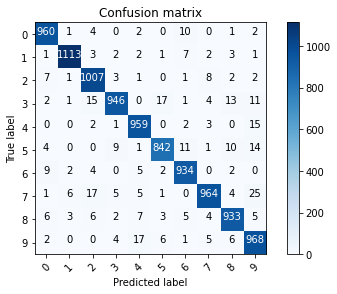

In [128]:
def confusion_matrix_plot(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predicting the labels for the test dataset
y_pred = pred(nn, test_images)
# computing the confusion matrix
conf_mtx = confusion_matrix(test_labels, y_pred) 
# plotting the confusion matrix by calling the above function
confusion_matrix_plot(conf_mtx, classes = range(10)) 

### Displaying top 25 errors

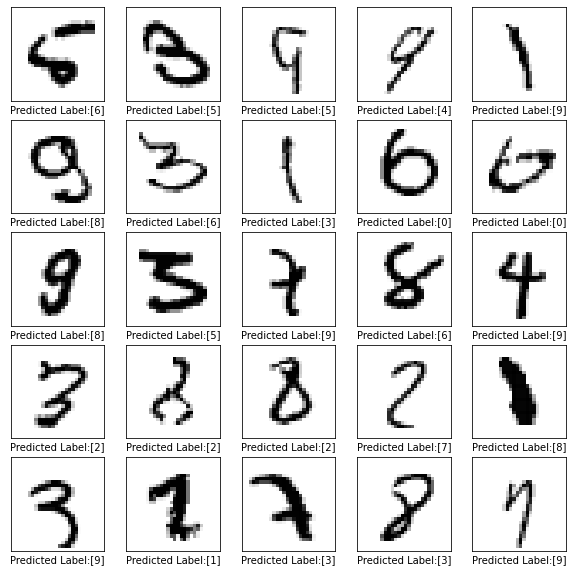

In [129]:
y_pred = pred(nn, test_images)
errors_indices = []
for i in range(0, len(y_pred)):
  #print("y_pred = " + str(y_pred[i]))
  #print("test_lable = " + str(test_labels[i]))
  if(y_pred[i] != test_labels[i]):
    errors_indices.append(i)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[errors_indices[i]].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel("Predicted Label:" + str([y_pred[errors_indices[i]]]))
plt.show()